# Segurança em Redes de Computadores - UECE - 2023.1


## Prof. JEB Maia - Trabalho 2


## CARLOS AUGUSTO OLIVEIRA DE AQUINO - 1394316



### Visão Geral

Análise do DataSet NSL-KDD e treinamento de um classificador e utilizando Árvore de Decisão do Sklearn. Foi utilizado a versão redusida do DataSet, que possui 25k de linhas e 38 colunas. Cobrindo 40 tipos de ataques diferentes. Na classificação binária, iremos classificar os dados em Normais ou Anômalos. Exploração de dados e representações gráficas utilizando pandas, seaborn, matplotlib e graphviz. Na classificação multiclasse, iremos classificar cada dado com seu respectivo rótulo de ataque. Ao final apresentei de maneira rápida a solução usando o Keras e Redes Neurais. Na classificação binária obteve-se uma média de 60% de acurácia e multiclasse obteve-se uma média 50% de acurácia. Já a solução usando Keras obteve-se uma média de 95% de precisão. Existem ainda outras soluções básicas usando apenas Sklearn, tais como:  RandomForestClassifier, GaussianNB, KNeighborsClassifier, etc. 

### Imports

In [74]:
import os, sys, re, time, math, tqdm, itertools
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint


### Préprocessamento dos Dados

In [75]:
# Todos os nomes de colunas presentes no Dataset
column_names = [
'duration','protocol_type','service','flag',
'src_bytes', 'dst_bytes', 'land','wrong_fragment','urgent','hot',
'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate','class'
] + ['Difficulty Level']
print('column names:', len(column_names))

column names: 43


Cria uma lista chamada column_names que contém os nomes das colunas do conjunto de dados. A lista inclui todas as características (features) do conjunto de dados, bem como a coluna "class" e "Difficulty Level". O número total de elementos na lista é impresso na saída.

Com base nessa informação, a lista column_names parece representar os nomes das colunas do conjunto de dados, incluindo a coluna do alvo ("class") e possivelmente uma coluna adicional chamada "Difficulty Level". 

In [76]:
#Possíveis Valores nas Variáveis Categóricas
possible_values = {
'protocol_type': ['tcp','udp', 'icmp'],
'service':['aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard',
'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger',
'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784',
'http_443', 'http_8001', 'imap4', 'IRC', 'iso_tsap', 'klogin', 'kshell',
'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns',
'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2',
'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp',
'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i',
'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois', 'X11', 'Z39_50'],
'flag': [ 'OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH' ],
'class': ['normal','apache2','back','buffer_overflow','ftp_write','guess_passwd','httptunnel','imap',
'ipsweep','land','loadmodule','mailbomb','mscan','multihop','named','neptune',
'nmap','perl','phf','pod','portsweep','processtable','ps','rootkit',
'saint','satan','sendmail','smurf','snmpgetattack','snmpguess','spy','sqlattack',
'teardrop','udpstorm','warezclient','warezmaster','worm','xlock','xsnoop', 'xterm']
}

Define um dicionário chamado possible_values que mapeia as possíveis categorias para as variáveis categóricas do conjunto de dados. O dicionário contém as seguintes chaves:

-protocol_type: Uma lista das possíveis categorias para a variável categórica "protocol_type", incluindo 'tcp', 'udp' e 'icmp'.

-service: Uma lista das possíveis categorias para a variável categórica "service", incluindo várias categorias como 'aol', 'auth', 'bgp', etc.
flag: Uma lista das possíveis categorias para a variável categórica "flag", incluindo 'OTH', 'REJ', 'RSTO', etc.

-class: Uma lista das possíveis categorias para a variável categórica "class", que parece ser o alvo (target) do problema de classificação. Inclui categorias como 'normal', 'apache2', 'back', 'buffer_overflow', etc.

Esse dicionário é útil para mapear os valores categóricos presentes no conjunto de dados em valores numéricos, como visto no código que você compartilhou anteriormente.

In [77]:
# Versão redusida do DataSet com 25k linhas e 43 colunas para treino
train_data = pd.read_csv('C:\\Users\\Carlos-Dell_LARCES\\OneDrive\\Documentos\\RepositoryGit\\HIDS_DT\\KDDTrain+_20Percent.txt', sep=',', header = None)
# Versão redusida do DataSet com 12k linhas e 43 colunas para testes
test_data = pd.read_csv('C:\\Users\\Carlos-Dell_LARCES\\OneDrive\\Documentos\\RepositoryGit\\HIDS_DT\\KDDTest-21.txt', sep=',', header = None)

Carrega os dados de treinamento e teste a partir de arquivos CSV. O conjunto de dados de treinamento é carregado do arquivo 'KDDTrain+_20Percent.txt' e o conjunto de dados de teste é carregado do arquivo 'KDDTest-21.txt'. Ambos os arquivos estão localizados nos caminhos especificados.

In [78]:
# Imprime o formato dos DataSets de Treino e Teste: 25k x 43 e 12k x 43
train_data.shape, test_data.shape

((25192, 43), (11850, 43))

Após o carregamento dos dados, o código imprime as dimensões dos conjuntos de dados de treinamento e teste usando a propriedade "shape". Isso retorna uma tupla com o número de linhas e colunas de cada conjunto de dados.

In [79]:
train_data.columns = column_names
test_data.columns = column_names

In [80]:
# Mapeamento para a coluna protocol_type
mapping = {'tcp': 1, 'udp': 2, 'icmp': 3}
train_data.protocol_type = train_data.protocol_type.map(mapping)
test_data.protocol_type = test_data.protocol_type.map(mapping)

In [81]:
# Mapeamento para a coluna service
mapping = {v:i+1 for i, v in enumerate(possible_values['service']) }
train_data.service = train_data.service.map(mapping)
test_data.service = test_data.service.map(mapping)

In [82]:
# Mapeamento para a coluna flag
mapping = {v:i+1 for i, v in enumerate(possible_values['flag']) }
train_data.flag = train_data.flag.map(mapping)
test_data.flag = test_data.flag.map(mapping)

In [83]:
# Mapeamento para a coluna class
mapping = {v:i for i, v in enumerate(possible_values['class']) }
train_data['class'] = train_data['class'].map(mapping)
test_data['class'] = test_data['class'].map(mapping)

Nesse trecho de código, estão sendo aplicados mapeamentos para as colunas categóricas dos conjuntos de dados de treinamento e teste.

-Para a coluna "protocol_type", um mapeamento é aplicado usando o dicionário mapping, onde 'tcp' é mapeado para 1, 'udp' é mapeado para 2 e 'icmp' é mapeado para 3.

-Para a coluna "service", um mapeamento é aplicado usando um dicionário criado com base nos possíveis valores encontrados no dicionário possible_values. Os valores da coluna são mapeados para números inteiros sequenciais começando de 1.

-Para a coluna "flag", um mapeamento é aplicado de maneira semelhante à coluna "service", usando um dicionário criado com base nos possíveis valores encontrados no dicionário possible_values.

-Para a coluna "class", um mapeamento é aplicado usando um dicionário criado com base nos possíveis valores encontrados no dicionário possible_values. Os valores da coluna são mapeados para números inteiros sequenciais começando de 0.

In [84]:
# Dados de trinamento
X_design, y_design = train_data.values[:,:-2], train_data.values[:,-2]
X_test, y_test = test_data.values[:,:-2], test_data.values[:,-2]


As variáveis X_design e y_design são criadas a partir dos valores do conjunto de dados de treinamento, excluindo as duas últimas colunas. A variável X_design contém todas as colunas, exceto as duas últimas, que são as features de entrada para o modelo de classificação, e a variável y_design contém a última coluna, que é o alvo (target) para o modelo de classificação.

Da mesma forma, as variáveis X_test e y_test são criadas a partir dos valores do conjunto de dados de teste, excluindo as duas últimas colunas.


In [85]:
np.unique(y_design)

array([ 0.,  2.,  3.,  4.,  5.,  7.,  8.,  9., 10., 13., 15., 16., 18.,
       19., 20., 23., 25., 27., 30., 32., 34., 35.])

In [86]:
np.unique(y_test)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 35., 36., 37., 38., 39.])

Os trechos "np.unique(y_design)" e "np.unique(y_test)" retornam os valores únicos presentes nas variáveis "y_design" e "y_test", ou seja, ele retorna os diferentes rótulos/classes que estão sendo utilizados no problema de classificação.

O resultado desse código será um array contendo os rótulos/classes únicos presentes em "y_design" e "y_test".

In [87]:
# Categorias que não estão do DataSet de Teste
y_indexes = [y_ for y_ in np.unique(y_design) if y_ not in np.unique(y_test)]
print(y_indexes)
print([possible_values['class'][int(y_index)] for y_index in y_indexes])

[30.0, 34.0]
['spy', 'warezclient']


Nesse trecho de código, está sendo verificado quais categorias presentes no conjunto de treinamento "(y_design) não estão presentes no conjunto de teste (y_test). Essas categorias foram removidas no trecho "Dados de Treinamento".

A lista "y_indexes" é criada utilizando uma list comprehension. Ela percorre os valores únicos de "y_design" utilizando "np.unique(y_design)" e verifica quais desses valores não estão presentes em "np.unique(y_test)". Esses valores são armazenados em "y_indexes".

Em seguida, o código imprime os índices das categorias que estão presentes em "y_design" mas não em "y_test", utilizando a lista "y_indexes".

Além disso, o código imprime os nomes das categorias correspondentes às categorias encontradas em "y_indexes", utilizando o dicionário "possible_values['class']" e convertendo os índices para inteiros.

In [88]:
# Categorias que não estão no DataSet de Treinamento
y_indexes = [y_ for y_ in np.unique(y_test) if y_ not in np.unique(y_design)]
print(y_indexes)
print([possible_values['class'][int(y_index)] for y_index in y_indexes])

[1.0, 6.0, 11.0, 12.0, 14.0, 17.0, 21.0, 22.0, 24.0, 26.0, 28.0, 29.0, 31.0, 33.0, 36.0, 37.0, 38.0, 39.0]
['apache2', 'httptunnel', 'mailbomb', 'mscan', 'named', 'perl', 'processtable', 'ps', 'saint', 'sendmail', 'snmpgetattack', 'snmpguess', 'sqlattack', 'udpstorm', 'worm', 'xlock', 'xsnoop', 'xterm']


Mesma verificação realizada na etapa anterior, mas agora para o data set de treinamento.

In [89]:
min_max_scaler = MinMaxScaler()
X_design = min_max_scaler.fit_transform(X_design)
X_test = min_max_scaler.transform(X_test)
X_design.min(), X_design.max(), X_test.min(), X_test.max()

(0.0, 1.0, -0.00196078431372549, 5.0)

Nesse trecho de código, está sendo aplicada a técnica de normalização usando o "MinMaxScaler" do scikit-learn.

Primeiro, é criado uma instância do "MinMaxScaler" chamada "min_max_scaler".

Em seguida, a função "fit_transform()" é aplicada ao conjunto de treinamento "X_design" utilizando "min_max_scaler". Essa função ajusta a escala dos dados e normaliza as features do conjunto de treinamento.

Depois, a função "transform()" é aplicada ao conjunto de teste "X_test" utilizando o mesmo min_max_scaler ajustado previamente. Essa função aplica a mesma transformação de escala aos dados do conjunto de teste.

Por fim, o código imprime o valor mínimo e máximo das variáveis "X_design" e "X_test" utilizando os métodos "min()" e "max()".

Os valores impressos representam o intervalo mínimo e máximo das features após a normalização. Garantir que as features estejam dentro de um intervalo específico pode ser útil para evitar problemas relacionados à escala dos dados e para garantir que as features estejam na mesma faixa de valores.

In [90]:
#Dividir os Dados em duas partições

X_train, X_eval, y_train, y_eval = tts(X_design, y_design, test_size = 0.20,random_state=42, shuffle = True)
X_train.shape, X_eval.shape, X_test.shape

((20153, 41), (5039, 41), (11850, 41))

A função "train_test_split" do scikit-learn está sendo utilizada para dividir o conjunto de treinamento "X_design" e "y_design" em conjuntos de treinamento e avaliação (ou validação).

A função "train_test_split" recebe como argumentos "X_design", "y_design" e outros parâmetros, como "test_size" (tamanho do conjunto de avaliação em relação ao conjunto de treinamento), "random_state" (semente aleatória) e "shuffle" (indicando se os dados devem ser embaralhados antes da divisão).

O resultado da função train_test_split é a divisão dos dados em quatro conjuntos: "X_train" (features de treinamento), "X_eval" (features de avaliação), "y_train" (rótulos de treinamento) e "y_eval" (rótulos de avaliação).

Por fim, o código imprime as dimensões dos conjuntos "X_train", "X_eval" e "X_test" utilizando o atributo shape para verificar o número de instâncias e features em cada conjunto.

In [91]:
y_design_ad = (y_design > 0).astype(np.float64)
y_train_ad = (y_train > 0).astype(np.float64)
y_eval_ad = (y_eval > 0).astype(np.float64)
y_test_ad = (y_test > 0).astype(np.float64)

Nesse trecho de código, está sendo abordada a detecção de anomalias como uma classificação binária. 
Essa abordagem transforma o problema de detecção de anomalias em um problema de classificação binária, onde as amostras são classificadas como Normal (0) ou Anomalia (1). Isso permite utilizar algoritmos de classificação binária para treinar e avaliar o modelo de detecção de anomalias.

### Classificação Binária

##### Testes com "test_size = 0.20" -> 20% dos dados serão usados como conjunto de teste, enquanto os outros 80% serão usados como conjunto de treinamento.

In [92]:
dt_parameters = {
'criterion' :['gini', 'entropy'],
'max_depth': [5,10,20,25,30,35,50],
}
grid_search = GridSearchCV(DecisionTreeClassifier(), dt_parameters, cv=10,
scoring='accuracy')
grid_search.fit(X_design, y_design_ad)
best_params_ = grid_search.best_params_
print(best_params_)

{'criterion': 'entropy', 'max_depth': 30}


Agora estamos realizando um ajuste de hiperparâmetros para encontrar os melhores parâmetros para o classificador de árvore de decisão usando a técnica de busca em grade (GridSearchCV) do scikit-learn.

In [93]:
best_criterion = 'entropy'
model = DecisionTreeClassifier(criterion = best_params_['criterion'], max_depth=best_params_['max_depth'])
model.fit(X_design, y_design_ad)

DecisionTreeClassifier(criterion='entropy', max_depth=30)

É criado um objeto DecisionTreeClassifier com os parâmetros criterion e max_depth definidos pelos melhores parâmetros encontrados no passo anterior.

In [94]:
# Realizando Predições
y_predicted = model.predict(X_test)
y_probs = model.predict_proba(X_test)
y_predicted.shape, y_probs.shape

((11850,), (11850, 2))

O modelo é treinado utilizando as features de treinamento (X_design) e os rótulos transformados (y_design_ad).

Em seguida, são obtidas as previsões do modelo tanto em formato de rótulos (y_predicted) quanto em formato de probabilidades (y_probs).

In [95]:
#Obtendo a Matriz de Confusão
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted, labels = [0, 1]).ravel()
display(pd.DataFrame([[tn, fp], [fn,tp]],
columns = ['Predicted N', 'Predicted P'],
index = ['Actual N', 'Actual P']))

,Predicted N,Predicted P
Actual N,1871,281
Actual P,4416,5282


É calculada a matriz de confusão utilizando a função "confusion_matrix" do sklearn.metrics. Os valores verdadeiros e previstos são comparados e os resultados são armazenados nas variáveis tn, fp, fn e tp. Esses valores são utilizados para criar um DataFrame que exibe a matriz de confusão com as labels 'Predicted N', 'Predicted P', 'Actual N' e 'Actual P'.

Uma matriz de confusão, também conhecida como tabela de contingência, é uma ferramenta utilizada para avaliar o desempenho de um modelo de classificação. Ela mostra a quantidade de acertos e erros do modelo ao prever as classes de um conjunto de dados.

A matriz de confusão possui duas dimensões principais: as classes reais e as classes previstas pelo modelo. Ela é organizada em uma tabela quadrada, em que cada célula representa a contagem de instâncias classificadas de uma determinada forma.

-TP (True Positive): número de instâncias que foram corretamente classificadas como positivas.

-FP (False Positive): número de instâncias que foram erroneamente classificadas como positivas (falsos positivos).

-FN (False Negative): número de instâncias que foram erroneamente classificadas como negativas (falsos negativos).

-TN (True Negative): número de instâncias que foram corretamente classificadas como negativas.

A partir desses valores, é possível calcular diversas métricas de desempenho do modelo, como a acurácia, a precisão, o recall (taxa de verdadeiros positivos) e a F1-score (média harmônica entre precisão e recall).

A matriz de confusão é uma ferramenta útil para analisar o desempenho do modelo em diferentes classes e identificar possíveis erros de classificação. Ela fornece informações importantes para entender as áreas onde o modelo pode estar tendo dificuldades e orientar melhorias no processo de classificação.

In [96]:
#Computando as Métricas
#acc = sklearn.metrics.accuracy_score(y_test_ad, y_predicted)
f1 = sklearn.metrics.f1_score(y_test_ad, y_predicted, labels = [0, 1])
auc = sklearn.metrics.roc_auc_score(y_test_ad, y_probs[:, 1])
fpr = fp / (fp + tn)
#print(f'ACC: {acc*100:.2f}%')
#print(f'FPR: {fpr*100:.2f}%')

accuracy_binary = sklearn.metrics.accuracy_score(y_test_ad, y_predicted)
precision_binary = sklearn.metrics.precision_score(y_test_ad, y_predicted)
recall_binary = sklearn.metrics.recall_score(y_test_ad, y_predicted)
f1_score_binary = sklearn.metrics.f1_score(y_test_ad, y_predicted)


print(f'Acurácia: {accuracy_binary*100:.2f}%'.format(accuracy_binary))
print(f'Precisão: {precision_binary*100:.2f}%'.format(precision_binary))
print(f'Revocação: {recall_binary*100:.2f}%'.format(recall_binary))
print(f'Medida F1: {f1_score_binary*100:.2f}%'.format(f1_score_binary))
print(f'FPR: {fpr*100:.2f}%')



Acurácia: 60.36%
Precisão: 94.95%
Revocação: 54.46%
Medida F1: 69.22%
FPR: 13.06%


São calculadas diversas métricas de avaliação do modelo, como acurácia (acc), pontuação F1 (f1), área sob a curva ROC (auc) e taxa de falsos positivos (fpr).

Por fim, os valores de acurácia, taxa de falsos positivos e as métricas são impressos.

Com 20% dos dados usados nos conjunto de teste e o DataSet reduzido obtivemos uma Acurácia de 60.46% e 12.96% de Falsos Positivos. 

In [97]:
confusion_matrix_binary = sklearn.metrics.confusion_matrix(y_test_ad, y_predicted)

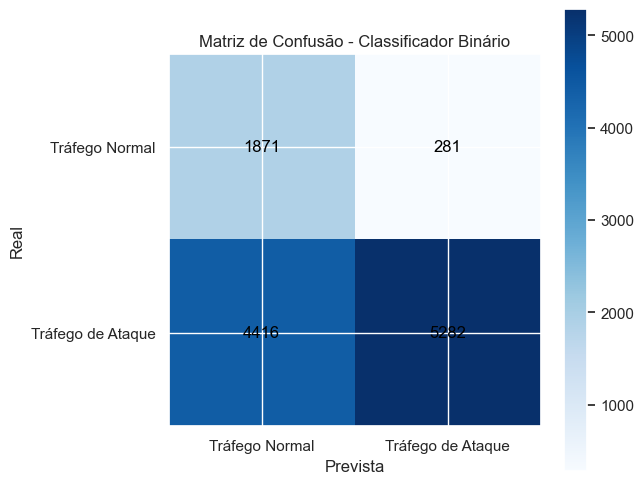

In [98]:
# Desenhando a matriz de confusão do Classificador Binário
plt.figure(figsize=(6, 6))
plt.imshow(confusion_matrix_binary, cmap='Blues')
plt.title('Matriz de Confusão - Classificador Binário')
plt.colorbar()
plt.xticks([0, 1], ['Tráfego Normal', 'Tráfego de Ataque'])
plt.yticks([0, 1], ['Tráfego Normal', 'Tráfego de Ataque'])
plt.xlabel('Prevista')
plt.ylabel('Real')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix_binary[i, j]), ha='center', va='center', color='black')

plt.show()


Utilizamos "matplotlib.pyplot" para fazer a representação gráfica da Matriz de Confusão Binária.

### Classificação Multiclasse

In [99]:
X_train, X_eval, y_train, y_eval = tts(X_design, y_design, test_size = 0.20, random_state=42, shuffle = True)
X_train.shape, X_eval.shape, X_test.shape

((20153, 41), (5039, 41), (11850, 41))

In [100]:
# Categories in the Data
# 0 (Normal)
# 1 .. 39 Anomaly types
np.unique(np.hstack([y_design.ravel(), y_test.ravel()]))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39.])

In [101]:
# Get the best parameters for a classifier, by using Grid Search Method
dt_parameters = {
'criterion' :['gini', 'entropy'],
'max_depth': [5,10,15,20,25,25,50],
}
grid_search = GridSearchCV(DecisionTreeClassifier(), dt_parameters, cv=5,
scoring='accuracy')
grid_search.fit(X_design, y_design)
best_params_ = grid_search.best_params_
print(best_params_)

C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



{'criterion': 'entropy', 'max_depth': 15}


In [102]:
model = DecisionTreeClassifier(criterion = best_params_['criterion'], max_depth=best_params_['max_depth'])
model.fit(X_design, y_design)


DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [103]:
# get predictions
y_predicted = model.predict(X_test)
y_probs = model.predict_proba(X_test)

In [104]:
# get the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_predicted)
df_cm = pd.DataFrame(
data = cm,
)
styled_df_cm = df_cm.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '6pt')]}])
display(styled_df_cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,1871,0,3,1,2,0,0,1,3,0,1,0,0,0,0,0,0,0,0,44,38,0,0,0,0,145,0,1,0,0,0,37,0,4,1,0,0,0,0
1,281,0,449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,6,0,0,0,0,0
2,0,0,359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0
6,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,0,0,0,0,137,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


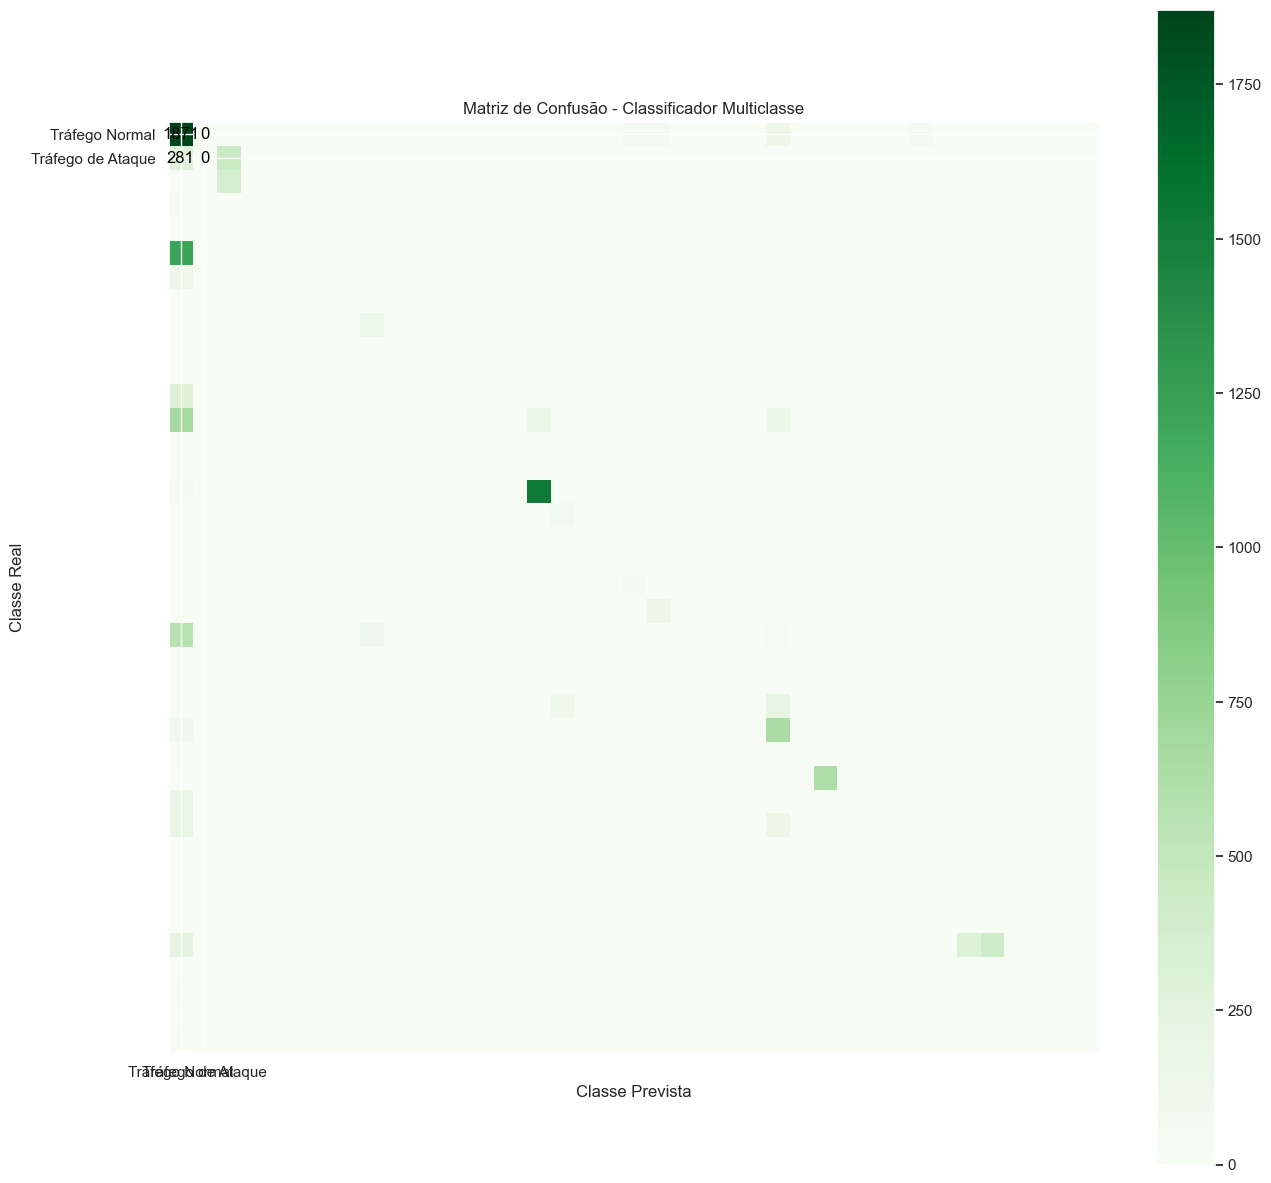

In [105]:
plt.figure(figsize=(15, 15))
plt.imshow(cm, cmap='Greens')
plt.title('Matriz de Confusão - Classificador Multiclasse')
plt.colorbar()
plt.xticks([0, 1], ['Tráfego Normal', 'Tráfego de Ataque'])
plt.yticks([0, 1], ['Tráfego Normal', 'Tráfego de Ataque'])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()

In [106]:
# compute metrics
#acc = sklearn.metrics.accuracy_score(y_test, y_predicted)
#print(f'ACC: {acc*100:.2f}%')


accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
precision = sklearn.metrics.precision_score(y_test, y_predicted, average='weighted')
recall = sklearn.metrics.recall_score(y_test, y_predicted, average='weighted')
f1_score = sklearn.metrics.f1_score(y_test, y_predicted, average='weighted')

fpr = fp / (fp + tn)

print(f'Acurácia: {accuracy*100:.2f}%'.format(accuracy))
print(f'Precisão: {precision*100:.2f}%'.format(precision))
print(f'Revocação: {recall*100:.2f}%'.format(recall))
print(f'Medida F1: {f1_score*100:.2f}%'.format(f1_score))
print(f'FPR: {fpr*100:.2f}%')

Acurácia: 49.33%
Precisão: 37.43%
Revocação: 49.33%
Medida F1: 39.30%
FPR: 13.06%


C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [107]:
# "Build a text report showing the main classification metrics" (from the docs)
report = sklearn.metrics.classification_report(y_test, y_predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.32      0.87      0.47      2152
         1.0       0.00      0.00      0.00       737
         2.0       0.44      1.00      0.61       359
         3.0       0.62      0.25      0.36        20
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00      1231
         6.0       0.00      0.00      0.00       133
         7.0       0.00      0.00      0.00         1
         8.0       0.56      0.97      0.71       141
         9.0       0.00      0.00      0.00         7
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00       293
        12.0       0.00      0.00      0.00       996
        13.0       0.00      0.00      0.00        18
        14.0       0.00      0.00      0.00        17
        15.0       0.90      0.97      0.93      1579
        16.0       0.41      0.95      0.57        73
        17.0       0.00    

C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Carlos-Dell_LARCES\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn

### Tensor Flow e Keras

In [108]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [109]:
# importing dataset
data = pd.read_csv('IDS.csv',names=col_names, header=None)


In [110]:
data


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [111]:
data.shape

(125973, 42)

In [112]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
print('Number of Rows (Samples): %s' % str((data.shape[0])))
print('Number of Columns (Features): %s' % str((data.shape[1])))


Number of Rows (Samples): 125973
Number of Columns (Features): 42


In [114]:
data.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal


In [115]:
# number of attack labels 
data['label'].value_counts()

label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

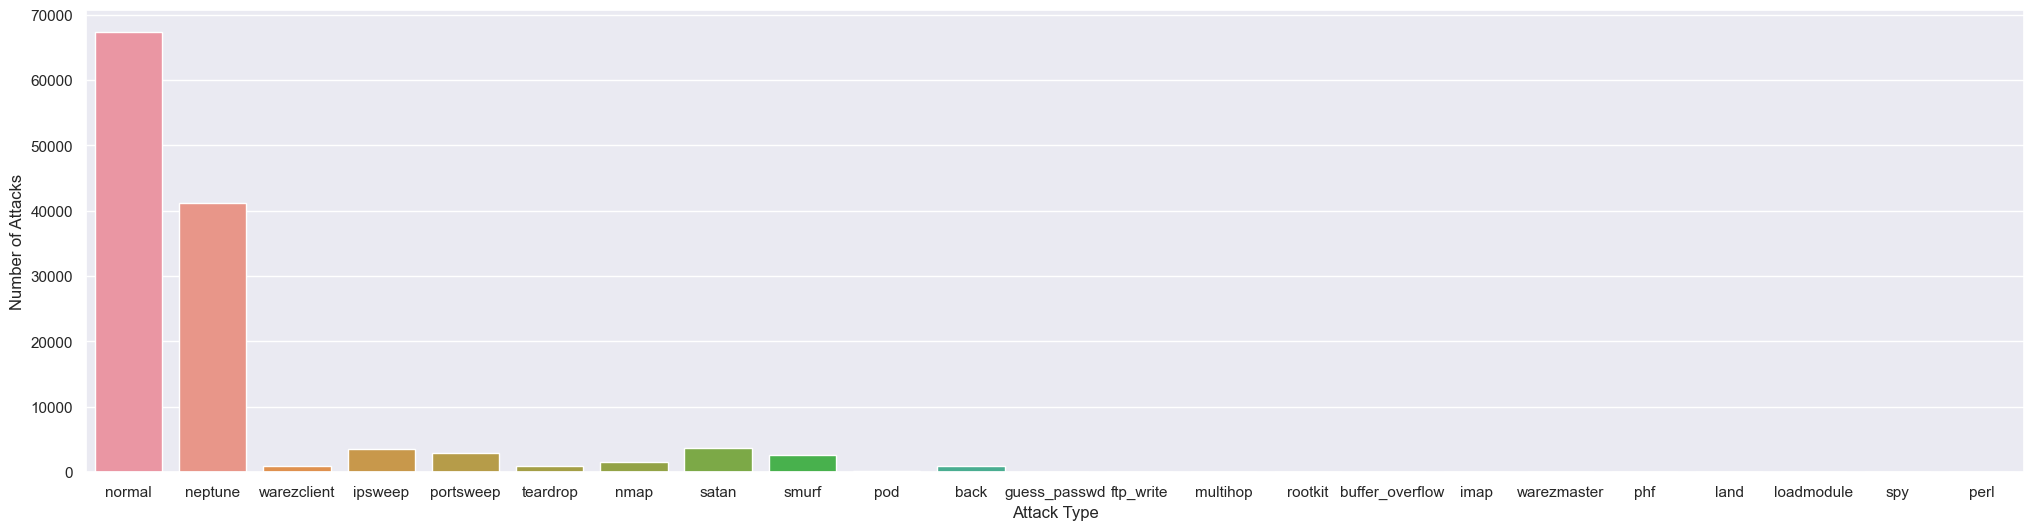

In [116]:
sns.set(rc={'figure.figsize':(25, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='label', data=data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [117]:
# changing attack labels to their respective attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [118]:
# calling change_label() function
change_label(data)

In [119]:
# distribution of attack classes
data.label.value_counts()

label
normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

In [120]:
# selecting numeric attributes columns from data
numeric_col = data.select_dtypes(include='number').columns

In [121]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

In [122]:
# data before normalization
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [123]:
# selecting categorical data attributes
cat_col = ['protocol_type','service','flag']

In [124]:
# creating a dataframe with only categorical attributes
categorical = data[cat_col]
categorical

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF
...,...,...,...
125968,tcp,private,S0
125969,udp,private,SF
125970,tcp,smtp,SF
125971,tcp,klogin,S0


In [125]:
# one-hot-encoding categorical attributes using pandas.get_dummies() function
categorical = pd.get_dummies(categorical,columns=cat_col)
categorical.to_csv("catgorical.csv",index=False)
categorical.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


#### Classificação Binária

In [126]:
#changing attack labels into two categories 'normal' and 'abnormal'
bin_label = pd.DataFrame(data.label.map(lambda x:'normal' if x=='normal' else 'abnormal'))

In [127]:
# creating a dataframe with binary labels (normal,abnormal)
bin_data = data.copy()
bin_data['label'] = bin_label

In [128]:
# label encoding (0,1) binary labels (abnormal,normal)
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['intrusion'] = enc_label

In [129]:
le1.classes_

array(['abnormal', 'normal'], dtype=object)

In [130]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

In [131]:
# one-hot-encoding attack label
bin_data = pd.get_dummies(bin_data,columns=['label'],prefix="",prefix_sep="") 
bin_data['label'] = bin_label
bin_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,abnormal,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,False,True,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,False,True,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,1,False,True,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal


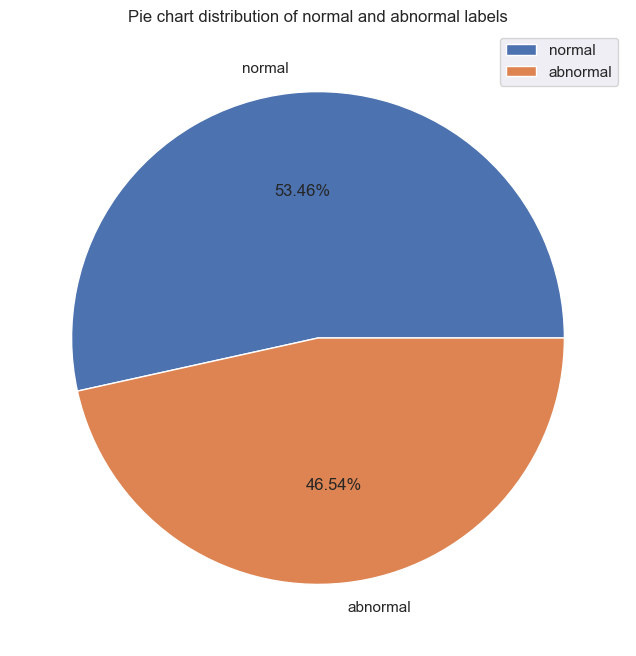

In [132]:
# pie chart distribution of normal and abnormal labels
plt.figure(figsize=(8,8))
plt.pie(bin_data.label.value_counts(),labels=bin_data.label.unique(),autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels")
plt.legend()
#plt.savefig('plots/Pie_chart_binary.png')
plt.show()

#### Classificação Multiclasse

In [133]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = data.copy()
multi_label = pd.DataFrame(multi_data.label)

In [134]:
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,Dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos


In [135]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

In [136]:
le2.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [137]:
np.save("le2_classes.npy",le2.classes_,allow_pickle=True)

In [138]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,Dos,Probe,R2L,U2R,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.00,0.05,0.00,4,False,False,False,False,True,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.00,0.00,4,False,False,False,False,True,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,True,False,False,False,False,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.01,0.00,0.01,4,False,False,False,False,True,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,4,False,False,False,False,True,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,True,False,False,False,False,Dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.00,0.00,0.00,4,False,False,False,False,True,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.01,0.00,4,False,False,False,False,True,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,True,False,False,False,False,Dos


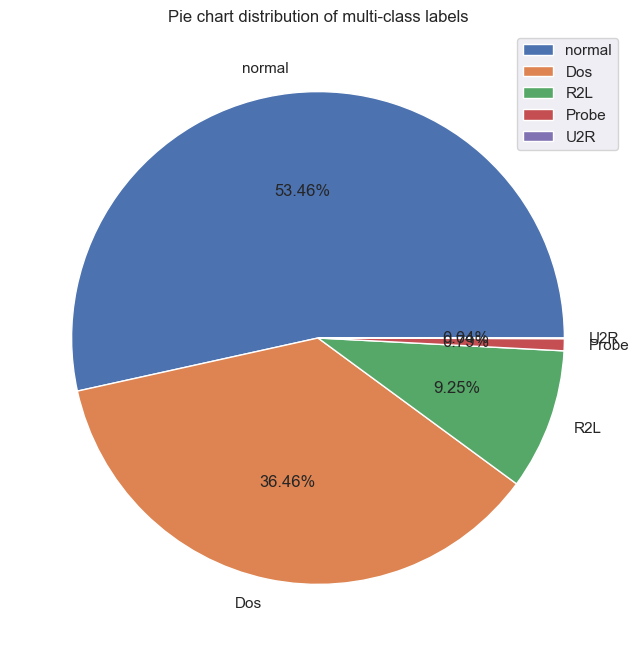

In [139]:
# pie chart distribution of multi-class labels
plt.figure(figsize=(8,8))
plt.pie(multi_data.label.value_counts(),labels=multi_data.label.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend()
#plt.savefig('plots/Pie_chart_multi.png')
plt.show()

In [140]:
bin_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,abnormal,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,False,True,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,False,True,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,1,False,True,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,1,False,True,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,True,False,abnormal
